In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from fleck import generate_spots, Star as Stars
from scipy.stats import ks_2samp, anderson_ksamp

In [2]:
amps_fast = 100 * np.load('../smamps/data/ngc_amps.npy')

//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 6., 10.,  8.,  6.,  9., 13., 18., 27., 47., 11.]),
 array([-2.7115023 , -2.4211452 , -2.1307881 , -1.840431  , -1.55007391,
        -1.25971681, -0.96935971, -0.67900261, -0.38864552, -0.09828842,
         0.19206868]),
 <a list of 10 Patch objects>)

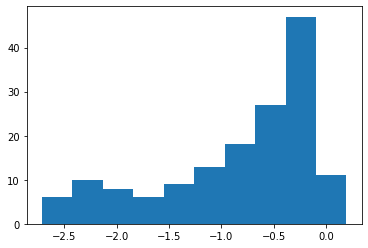

In [3]:
plt.hist(np.log10(amps_fast))

In [4]:
ld = [0.5079, 0.2239]
stars = Stars(spot_contrast=0.7, n_phases=30, u_ld=ld)
n_inclinations = 50
spot_radius = 0.2
n_spots = 3
# min_smoothed_amp = 0.01336
stars = Stars(spot_contrast=0.7, n_phases=30, u_ld=ld)

In [5]:
def ad(spot_radius, max_latitude, spot_contrast):
    stars.spot_contrast = spot_contrast
    lons, lats, rads, incs = generate_spots(min_latitude=-max_latitude, max_latitude=max_latitude, n_spots=n_spots,
                                            spot_radius=spot_radius, n_inclinations=n_inclinations)
    lcs = stars.light_curve(lons, lats, rads, incs)
    smoothed_amps = 100 * lcs.ptp(axis=0)
#     smoothed_amps = smoothed_amps[smoothed_amps > min_smoothed_amp]
    if len(smoothed_amps) < 1: 
        anderson_stat = 100
    else: 
        anderson_stat = anderson_ksamp([np.log10(smoothed_amps), np.log10(amps_fast)]).statistic
    return anderson_stat

n_steps = 50000
init_rad = 0.23
init_max_lat = 70
init_contrast = 0.7

In [6]:
p_values = [ad(init_rad, init_max_lat, init_contrast)]
spot_radii = [init_rad]
max_lats = [init_max_lat]
spot_contrasts = [init_contrast]
steps = 0
accepted_step = 0

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: p-value floored: true value smaller than 0.001
  # This is added back by InteractiveShellApp.init_path()


In [7]:
while accepted_step < n_steps: 
#     if steps > 0 and steps % 100 == 0: 
#         print(accepted_step, accepted_step/steps)
    spot_radius = 0.05 * np.random.randn() + spot_radii[accepted_step]
    max_lat = 5*np.random.randn() + max_lats[accepted_step]
    spot_contrast = 0.1*np.random.randn() + spot_contrasts[accepted_step]
    
    # Apply prior
    if 0 < spot_radius < 1 and 0 < max_lat < 90 and 0 < spot_contrast < 1:
        adstat = ad(spot_radius, max_lat, spot_contrast)

        steps += 1
        if adstat < 10: 
            # Accept step
            spot_radii.append(spot_radius)
            max_lats.append(max_lat)
            spot_contrasts.append(spot_contrast)
            p_values.append(adstat)
            accepted_step += 1

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: p-value floored: true value smaller than 0.001
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: p-value capped: true value larger than 0.25
  # This is added back by InteractiveShellApp.init_path()


In [8]:
print('acceptance rate:', accepted_step/steps)

acceptance rate: 0.3350667452956629


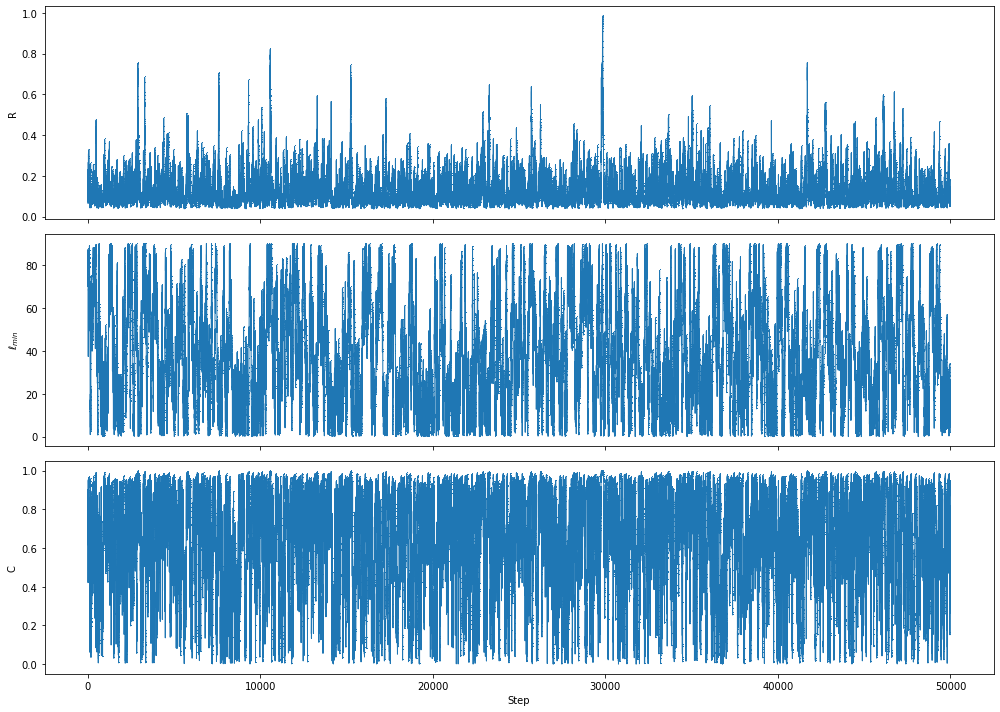

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
ax[0].plot(spot_radii, marker=',', lw=1)
ax[1].plot(max_lats, marker=',', lw=1)
ax[2].plot(spot_contrasts, marker=',', lw=1)
# ax[3].plot(p_values, marker=',', lw=0)

titles = ['R', '$\ell_{min}$', "C", '']
for axis, title in zip(ax, titles):
    axis.set_ylabel(title)
ax[-1].set_xlabel('Step')
fig.tight_layout()
# ax[2].set_ylim([-2, 3])

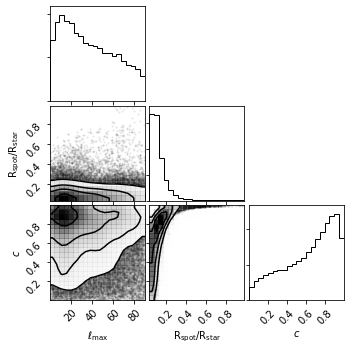

In [10]:
from corner import corner

fig, ax = plt.subplots(3, 3, figsize=(5, 5))
samples = np.array([max_lats, spot_radii, spot_contrasts]).T
corner(samples, labels='$\\rm\ell_{max}$ $\\rmR_{spot}/R_{star}$ $c$'.split(), smooth=True, fig=fig);
# fig.tight_layout()
plt.savefig('plots/corner_ngc6811.pdf', bbox_inches='tight')

In [11]:
np.save('data/ngc6811_samples.npy', samples)